In [3]:
import os
import sys
from datetime import datetime
import pandas as pd
# import pypinfo
import subprocess
from subprocess import CalledProcessError
import json
from tqdm.notebook import tqdm

from utilities import read_json, save_json, get_datestr_list

# Use this to figure out getting the keys in json
# https://www.youtube.com/watch?v=rWcLDax-VmM&t=3s

# Google console for PyPI data
# https://console.cloud.google.com/marketplace/product/gcp-public-data-pypi/pypi?q=search&referrer=search
# https://console.cloud.google.com/bigquery?p=bigquery-public-data&d=pypi&page=dataset

# Schema here
# https://packaging.python.org/en/latest/guides/analyzing-pypi-package-downloads/#data-schema

pd.set_option('display.max_columns', 100)

What installers are there: 
```sql
SELECT DISTINCT details.installer.name
FROM `bigquery-public-data.pypi.file_downloads`
WHERE timestamp BETWEEN TIMESTAMP('2023-04-01') AND TIMESTAMP('2023-05-01')
```
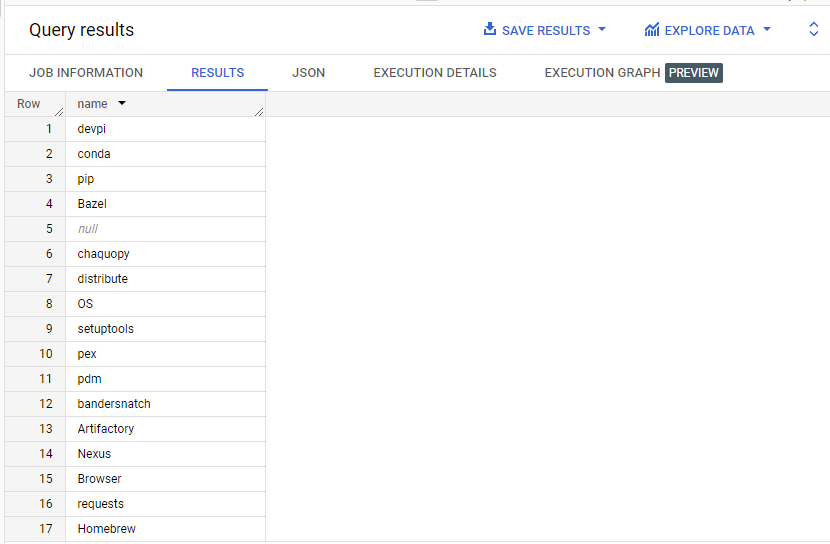

(Default = pip)

In [5]:
df = (
    pd
    .read_csv("../input/check-github-url.csv")
    .query("gh_url_check==1")
)
list_packages = df["pkg"].tolist()
df.head(3)

,pkg,return_code,github_url,homepage,earliest_release,gh_url_check,github
3,jawalang,200.0,https://github.com/Arsybai/jawa-language,https://github.com/Arsybai/jawa-language,2023-04-25T00:08:33,1.0,https://github.com/Arsybai/jawa-language
5,foccoerpy,200.0,https://github.com/GaNiziolek/FoccoERPy,NaN,2023-04-25T13:26:24,1.0,https://github.com/GaNiziolek/FoccoERPy
6,evaluateqa,200.0,https://github.com/MihailSalnikov/EvaluateQA,https://github.com/MihailSalnikov/EvaluateQA,2023-04-26T12:10:16,1.0,https://github.com/MihailSalnikov/EvaluateQA


In [11]:
start_date = "2023-04-24"
end_date = datetime.today().strftime("%Y-%m-%d")

dates = get_datestr_list(start_date, end_date)

date_tuples = [(dates[i], dates[i+1]) for i in range(len(dates)-1)]
date_tuples[:3], date_tuples[-3:]

([('2023-04-24', '2023-04-25'),
  ('2023-04-25', '2023-04-26'),
  ('2023-04-26', '2023-04-27')],
 [('2023-06-07', '2023-06-08'),
  ('2023-06-08', '2023-06-09'),
  ('2023-06-09', '2023-06-10')])

In [12]:
output_path = "../output/cache_pypi_downloads_payload"
for package in tqdm(list_packages):
    for day in date_tuples:
        start_date, end_date = day
#         print(start_date, end_date)
        filename = f"{start_date}_{end_date}_{package}.json"
        savepath = os.path.join(output_path, filename)
#         print(filename)
    
        # check if file already exist,
        if os.path.exists(savepath):
            # Assert that payload is correct
            cached_data = read_json(savepath)
            cached_package = cached_data["args"][-1]
            try:
                assert cached_package==package
                continue
            except AssertionError:
                print("Cached wrong package..re-querying..")
                pass
            
        # form shell command
        cmd = [
            "pypinfo", 
            "-j",  # return in JSON format
            "--start-date",
            f"{start_date}",
            "--end-date",
            f"{end_date}",
            f"{package}"  # pkg to query
        ]
        
        try:
            data = subprocess.run(cmd, text=True, check=True, capture_output=True)
            json_payload = json.loads(data.stdout)
            json_payload["args"] = data.args
            
            # save payload
            save_json(json_payload, savepath)
            
        except CalledProcessError as e:
            print(f"CalledProcessError - {cmd}")
            print(e.stderr)
            sys.exit(1)

  0%|          | 0/622 [00:00<?, ?it/s]